# Imports etc.

In [1]:
import numpy as np
import os
import pandas as pd
import plotnine as gg
gg.theme_set(gg.theme_classic)

In [2]:
data_dir = 'C:/Users/maria/MEGAsync/Berkeley/Aram2/task-2.2/data'

# Get data

In [116]:
# Get participant's actions
def read_in_good_structure(raw):
    
    subj_dat = pd.DataFrame()

    for phase in raw.columns[:2]:
        for block in raw.index:

            # Get raw phase data
            phase_raw = raw[phase][block]
            phase_dat = pd.DataFrame()

            # Turn raw phase data into nice dictonary
            for trial in range(len(phase_raw)):
                
                if type(phase_raw[trial]) == dict:  # remove trials that have [-3] as only content (not sure what happened)

                    trial_raw = phase_raw[trial]
                    n_steps = len(trial_raw['key_press'])
                    trial_dat = pd.DataFrame(
                        {'phase': phase,
                         'block': block,
                         'trial': trial,
                         'step': range(n_steps),
                         'action': trial_raw['key_press'],
                         'RT': trial_raw['reaction_times'],
                         'goal_star': trial_raw['star'],
                         'unlocked_star': trial_raw['unlock']
                        })

                    phase_dat = phase_dat.append(trial_dat)

            subj_dat = subj_dat.append(phase_dat)

    return subj_dat

# Example
read_in_good_structure(raw)

,phase,block,trial,step,action,RT,goal_star,unlocked_star
0,high_transfer,learning,0,0,0,3.722172,0,-1
1,high_transfer,learning,0,1,2,0.069558,0,-1
2,high_transfer,learning,0,2,1,0.090458,0,-1
3,high_transfer,learning,0,3,3,0.046296,0,-1
0,high_transfer,learning,1,0,0,0.443545,0,-1
...,...,...,...,...,...,...,...,...
3,low_transfer,transfer,148,3,1,0.106012,1,1
0,low_transfer,transfer,149,0,0,0.113788,1,1
1,low_transfer,transfer,149,1,2,0.026387,1,1
2,low_transfer,transfer,149,2,3,0.059811,1,1


In [4]:
# FOR MARIA DATA ONLY

def read_in_ugly_structure(raw):
    
    subj_dat = pd.DataFrame()

    phases = {'high_learning': ('high', 'learning'),
              'high_transfer': ('high', 'transfer'),
              'low_learning': ('past', 'low_transfer', 'learning'),
              'low_transfer': ('past', 'low_transfer', 'transfer')}

    for phase_name, phase_index in phases.items():

        # Get raw phase data
        if len(phase_index) == 2:
            phase_raw = raw[phase_index[0]][phase_index[1]]
        elif len(phase_index) == 3:
            phase_raw = raw[phase_index[0]][phase_index[1]][phase_index[2]]
        else:
            raise(ValueError)

        phase_dat = pd.DataFrame()

        # Turn raw phase data into nice dictonary
        for trial in range(len(phase_raw)):

            if type(phase_raw[trial]) == dict:
                
                trial_raw = phase_raw[trial]
                n_steps = len(trial_raw['key_press'])
                trial_dat = pd.DataFrame(
                    {'phase': phase_name.split('_')[0] + '_transfer',
                     'block': phase_name.split('_')[1],
                     'trial': trial,
                     'step': range(n_steps),
                     'action': trial_raw['key_press'],
                     'RT': trial_raw['reaction_times'],
                     'goal_star': trial_raw['star'],
                     'unlocked_star': trial_raw['unlock'],
#                      'unlocked_item': trial_raw['unlocked_item']
                    })

                phase_dat = phase_dat.append(trial_dat)

        subj_dat = subj_dat.append(phase_dat)
        
    return subj_dat

In [107]:
def read_in_one_subject(raw):
    
    # Read in raw data
    if raw.shape[0] == 3:
        subj_dat = read_in_ugly_structure(raw)
        
    elif raw.shape[0] == 2:
        subj_dat = read_in_good_structure(raw)
        
    # Add columns
    n_trials, n_trials_expected = subj_dat.shape[0], 2 * (150 * 4) + 2 * (300 * 4)
    subj_dat['trial_overall'] = range(n_trials)
    
    goal_star_change = (np.diff(subj_dat.goal_star) != 0)
    subj_dat['n_star'] = np.append(0, np.cumsum(goal_star_change))
    
    # Print message
    print("Subject did {} trials. Expected {}. Difference {}.".format(n_trials, n_trials_expected, n_trials_expected - n_trials))
        
    return subj_dat

# Example use
subj_dat = read_in_one_subject(raw)
subj_dat

Subject did 3592 trials. Expected 3600. Difference 8.


,phase,block,trial,step,action,RT,goal_star,unlocked_star,trial_overall,n_star
0,high_transfer,learning,0,0,0,3.722172,0,-1,0,0
1,high_transfer,learning,0,1,2,0.069558,0,-1,1,0
2,high_transfer,learning,0,2,1,0.090458,0,-1,2,0
3,high_transfer,learning,0,3,3,0.046296,0,-1,3,0
0,high_transfer,learning,1,0,0,0.443545,0,-1,4,0
...,...,...,...,...,...,...,...,...,...,...
3,low_transfer,transfer,148,3,1,0.106012,1,1,3587,35
0,low_transfer,transfer,149,0,0,0.113788,1,1,3588,35
1,low_transfer,transfer,149,1,2,0.026387,1,1,3589,35
2,low_transfer,transfer,149,2,3,0.059811,1,1,3590,35


In [108]:
file_names = [f for f in os.listdir(data_dir) if 'subj' in f]

all_data = pd.DataFrame()
for file_name in file_names:
    
    print("Reading in {}.".format(file_name))
    
    # Get raw json
    raw = pd.read_json(os.path.join(data_dir, file_name))
    
    # Format into pd.DataFrame
    subj_dat = read_in_one_subject(raw)
    subj_dat['ID'] = int(file_name.split('_')[1].split('.')[0])
    
    # Combine
    all_data = pd.concat([all_data, subj_dat])
    
all_data

Reading in subj_0.json.
Subject did 3600 trials. Expected 3600. Difference 0.
Reading in subj_1.json.
Subject did 3580 trials. Expected 3600. Difference 20.
Reading in subj_11.json.
Subject did 3600 trials. Expected 3600. Difference 0.
Reading in subj_2.json.
Subject did 3528 trials. Expected 3600. Difference 72.
Reading in subj_5.json.
Subject did 3592 trials. Expected 3600. Difference 8.
Reading in subj_6.json.
Subject did 3592 trials. Expected 3600. Difference 8.
Reading in subj_7.json.
Subject did 3412 trials. Expected 3600. Difference 188.
Reading in subj_8.json.
Subject did 3592 trials. Expected 3600. Difference 8.


,phase,block,trial,step,action,RT,goal_star,unlocked_star,trial_overall,n_star,ID
0,high_transfer,learning,0,0,2,4.097052,0,-1,0,0,0
1,high_transfer,learning,0,1,1,0.389956,0,-1,1,0,0
2,high_transfer,learning,0,2,3,0.352046,0,-1,2,0,0
3,high_transfer,learning,0,3,0,0.277259,0,-1,3,0,0
0,high_transfer,learning,1,0,2,10.580715,0,-1,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...
3,low_transfer,transfer,148,3,1,0.106012,1,1,3587,35,8
0,low_transfer,transfer,149,0,0,0.113788,1,1,3588,35,8
1,low_transfer,transfer,149,1,2,0.026387,1,1,3589,35,8
2,low_transfer,transfer,149,2,3,0.059811,1,1,3590,35,8


In [109]:
all_data = all_data.reset_index(drop=True)
all_data.loc[all_data.unlocked_star == -1, 'unlocked_star'] = np.nan
all_data['ACC'] = (all_data['unlocked_star'] == all_data['goal_star']).astype(int)
all_data['any_star'] = (all_data['unlocked_star'] > 0).astype(int)
all_data

,phase,block,trial,step,action,RT,goal_star,unlocked_star,trial_overall,n_star,ID,ACC,any_star
0,high_transfer,learning,0,0,2,4.097052,0,NaN,0,0,0,0,0
1,high_transfer,learning,0,1,1,0.389956,0,NaN,1,0,0,0,0
2,high_transfer,learning,0,2,3,0.352046,0,NaN,2,0,0,0,0
3,high_transfer,learning,0,3,0,0.277259,0,NaN,3,0,0,0,0
4,high_transfer,learning,1,0,2,10.580715,0,NaN,4,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28491,low_transfer,transfer,148,3,1,0.106012,1,1.0,3587,35,8,1,1
28492,low_transfer,transfer,149,0,0,0.113788,1,1.0,3588,35,8,1,1
28493,low_transfer,transfer,149,1,2,0.026387,1,1.0,3589,35,8,1,1
28494,low_transfer,transfer,149,2,3,0.059811,1,1.0,3590,35,8,1,1


In [110]:
all_data.describe()

,trial,step,action,RT,goal_star,unlocked_star,trial_overall,n_star,ID,ACC,any_star
count,28496.000000,28496.000000,28496.000000,28496.000000,28496.000000,16908.000000,28496.000000,28496.000000,28496.000000,28496.000000,28496.000000
mean,124.731050,1.500000,1.538602,0.305546,1.499579,1.502957,1781.018810,17.508843,4.996070,0.515722,0.484840
std,82.865993,1.118054,1.111625,0.783546,0.958372,0.979438,1029.158642,10.395070,3.545506,0.499762,0.499779
min,0.000000,0.000000,0.000000,0.000996,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,56.000000,0.750000,1.000000,0.096734,1.000000,1.000000,890.000000,8.000000,1.000000,0.000000,0.000000
50%,112.000000,1.500000,2.000000,0.183869,2.000000,2.000000,1780.500000,18.000000,5.000000,1.000000,0.000000
75%,187.000000,2.250000,3.000000,0.297211,2.000000,2.000000,2671.000000,26.250000,8.000000,1.000000,1.000000
max,299.000000,3.000000,3.000000,101.912674,3.000000,3.000000,3599.000000,35.000000,11.000000,1.000000,1.000000


In [111]:
# # Get participant's rules
# rules_dat = pd.DataFrame()

# for phase in raw.columns:
#     for block in raw.index:
        
#         rules_phase = pd.DataFrame(raw[phase][block][0]['rules'])
#         rules_phase['phase_block'] = '_'.join([phase, block])
#         rules_dat = rules_dat.append(rules_phase)
    
# rules_dat = rules_dat.reset_index(drop=True)
# rules_dat = rules_dat.drop(index=[1, 3, 5, 7])
# rules_dat = rules_dat.reset_index(drop=True)
# rules_dat

# Results

In [112]:
interesting_cols = ['RT', 'unlocked_star', 'ACC', 'any_star', 'trial_overall']
id_cols = ['ID', 'phase', 'block']
all_data[interesting_cols + id_cols].groupby(id_cols).mean()

RT  unlocked_star       ACC  any_star  \
ID phase         block                                                   
0  high_transfer learning  0.292363       1.313609  0.453333  0.366667   
                 transfer  0.228485       1.558140  0.846667  0.860000   
   low_transfer  learning  0.366247       2.166667  0.463333  0.576667   
                 transfer  0.312938       1.745455  0.240000  0.353333   
1  high_transfer learning  0.312388       1.708333  0.736667  0.686667   
                 transfer  0.336014       1.797980  0.566667  0.640000   
   low_transfer  learning  0.412222       1.250000  0.587838  0.402027   
                 transfer  0.549511       1.443038  0.429530  0.489933   
2  high_transfer learning  0.366662       1.271186  0.760274  0.547945   
                 transfer  0.365703       1.372093  0.524138  0.544828   
   low_transfer  learning  0.254808       1.483019  0.859532  0.638796   
                 transfer  0.282554       1.554455  0.636986  0.671233   
5  high_transfer learning  0.318221       1.377451  0.640000  0.436667   
                 transfer  0.234435       1.988636  0.483221  0.563758   
   low_transfer  learning  0.327599       1.131387  0.404682  0.371237   
                 transfer  0.307132       1.457944  0.700000  0.706667   
6  high_transfer learning  0.279323       0.864662  0.253333  0.190000   
                 transfer  0.250892       1.727273  0.503356  0.550336   
   low_transfer  learning  0.253142       1.853107  0.540000  0.543333   
                 transfer  0.281573       1.467532  0.469799  0.496644   
7  high_transfer learning  0.269370       1.408333  0.780488  0.658537   
                 transfer  0.404628       1.786667  0.450382  0.541985   
   low_transfer  learning  0.448744       1.666667  0.335616  0.397260   
                 transfer  0.451613       1.804878  0.538462  0.573427   
8  high_transfer learning  0.253751       1.041667  0.310000  0.306667   
                 transfer  0.253932       1.677419  0.304054  0.351351   
   low_transfer  learning  0.174990       1.147059  0.580000  0.496667   
                 transfer  0.197494       1.625000  0.373333  0.413333   
11 high_transfer learning  0.230548       1.815029  0.520000  0.506667   
                 transfer  0.181843       1.556604  0.660000  0.693333   
   low_transfer  learning  0.334635       1.436364  0.256667  0.253333   
                 transfer  0.268557       1.000000  0.086667  0.093333   

                           trial_overall  
ID phase         block                    
0  high_transfer learning          599.5  
                 transfer         1499.5  
   low_transfer  learning         2399.5  
                 transfer         3299.5  
1  high_transfer learning          599.5  
                 transfer         1499.5  
   low_transfer  learning         2391.5  
                 transfer         3281.5  
2  high_transfer learning          583.5  
                 transfer         1457.5  
   low_transfer  learning         2345.5  
                 transfer         3235.5  
5  high_transfer learning          599.5  
                 transfer         1497.5  
   low_transfer  learning         2393.5  
                 transfer         3291.5  
6  high_transfer learning          599.5  
                 transfer         1497.5  
   low_transfer  learning         2395.5  
                 transfer         3293.5  
7  high_transfer learning          573.5  
                 transfer         1409.5  
   low_transfer  learning         2255.5  
                 transfer         3125.5  
8  high_transfer learning          599.5  
                 transfer         1495.5  
   low_transfer  learning         2391.5  
                 transfer         3291.5  
11 high_transfer learning          599.5  
                 transfer         1499.5  
   low_transfer  learning         2399.5  
                 transfer         3299.5

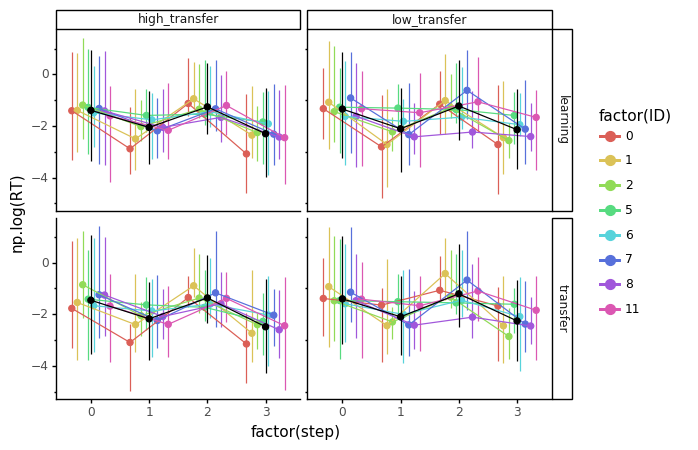

<ggplot: (125609975542)>

In [67]:
# RTs
g = (gg.ggplot(all_data, gg.aes('factor(step)', 'np.log(RT)', color='factor(ID)', group='ID'))
#      + gg.geom_point(position='jitter', alpha=0.3)
     + gg.stat_summary(fun_data='median_hilow', position=gg.position_dodge(width=0.75))
     + gg.stat_summary(fun_data='median_hilow', position=gg.position_dodge(width=0.75), geom='line')
     + gg.stat_summary(gg.aes(group=1), fun_data='median_hilow', color='black')
     + gg.stat_summary(gg.aes(group=1), fun_data='median_hilow', geom='line', color='black')
#      + gg.geom_violin()
#      + gg.geom_boxplot()
#      + gg.geom_hline(yintercept=5, linetype='dotted')
     + gg.facet_grid('block ~ phase')
    )
g

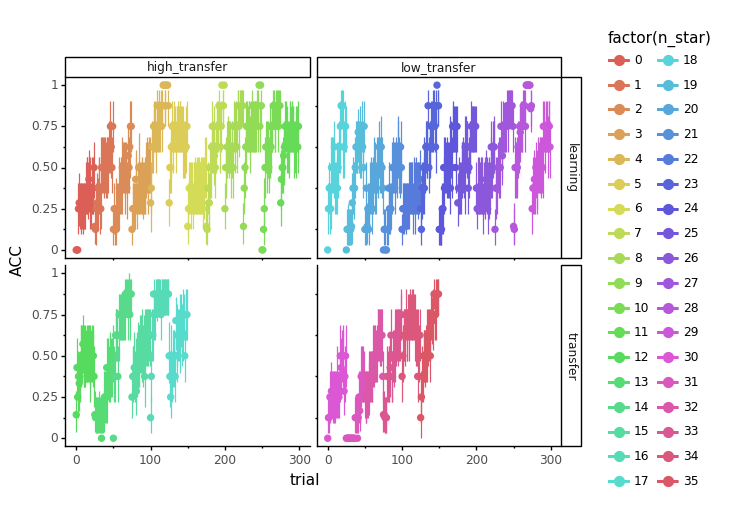

<ggplot: (-9223371911246227035)>

In [114]:
g = (gg.ggplot(all_data, gg.aes('trial', 'ACC', color='factor(n_star)'))
     + gg.stat_summary()
     + gg.facet_grid('block ~ phase')
    )
g

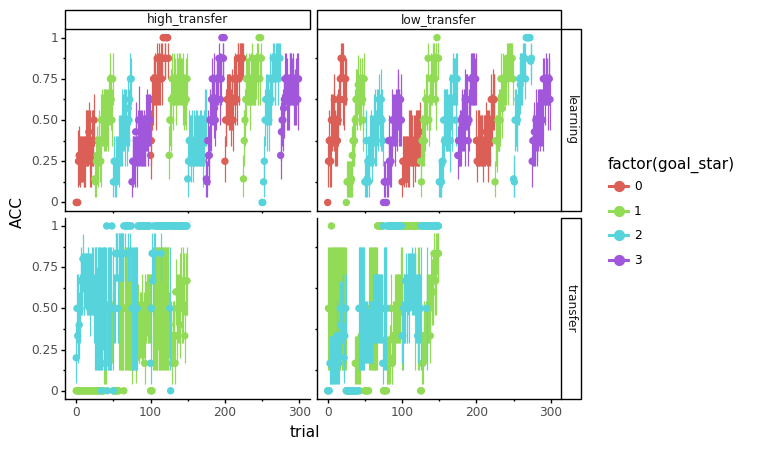

<ggplot: (125609690404)>

In [130]:
g = (gg.ggplot(all_data, gg.aes('trial', 'ACC', color='factor(goal_star)'))
     + gg.stat_summary()
     + gg.facet_grid('block ~ phase')
    )
g

In [127]:
id_cols = ['ID', 'phase', 'block', 'goal_star']
sum_dat = all_data.groupby(id_cols).mean().reset_index()[id_cols + ['ACC']]

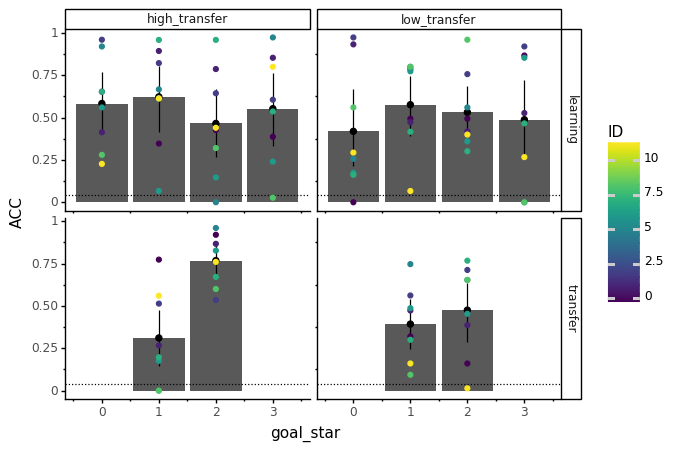

<ggplot: (-9223371911248446432)>

In [135]:
chance_perf = 1 / (4 * 3 * 2)
g = (gg.ggplot(sum_dat, gg.aes('goal_star', 'ACC'))
     + gg.stat_summary(geom='bar')
     + gg.stat_summary()
     + gg.geom_hline(yintercept=chance_perf, linetype='dotted')
     + gg.geom_point(gg.aes(color='ID'))
     + gg.facet_grid('block ~ phase')
    )
g

In [220]:
# Get data: Unlocking the wrong star
sub_dat = all_data[(np.invert(np.isnan(all_data.unlocked_star))) & (all_data.ACC == 0)]
id_cols = ['ID', 'phase', 'block', 'unlocked_star', 'trial']
sum_dat_pre = sub_dat.groupby(id_cols).mean().reset_index()[id_cols]
sum_dat = sum_dat_pre.groupby(id_cols[:-1]).count().reset_index()
sum_dat = sum_dat.rename(columns={'trial': 'n_unlocked'})
sum_dat_pre[:20], sum_dat[:20]

(    ID          phase     block  unlocked_star  trial
 0    0  high_transfer  learning            0.0     82
 1    0  high_transfer  learning            0.0    125
 2    0  high_transfer  learning            0.0    139
 3    0  high_transfer  learning            0.0    141
 4    0  high_transfer  learning            0.0    143
 5    0  high_transfer  learning            0.0    148
 6    0  high_transfer  learning            0.0    151
 7    0  high_transfer  learning            0.0    155
 8    0  high_transfer  learning            0.0    163
 9    0  high_transfer  learning            0.0    178
 10   0  high_transfer  learning            1.0     19
 11   0  high_transfer  learning            1.0     58
 12   0  high_transfer  learning            1.0     60
 13   0  high_transfer  learning            1.0     87
 14   0  high_transfer  learning            1.0     88
 15   0  high_transfer  learning            1.0    253
 16   0  high_transfer  learning            1.0    276
 17   0  h

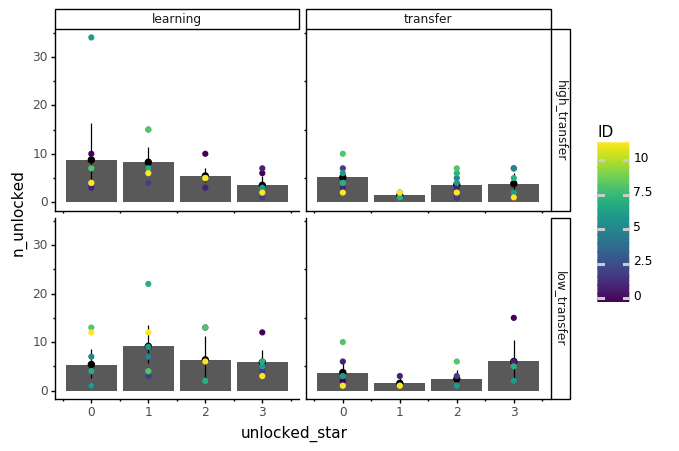

<ggplot: (-9223371911241924513)>

In [221]:
g = (gg.ggplot(sum_dat, gg.aes('unlocked_star', 'n_unlocked', color='ID'))
     + gg.stat_summary(geom='bar')
     + gg.stat_summary()
     + gg.geom_point()
     + gg.facet_grid('phase ~ block')
    )
g

# OLD

## Reading in Maria's data

## Adding middle-layer items

In [ ]:
# d = rules_dat.loc[(rules_dat.phase == 'high_transfer') & (rules_dat.block == 'learning')]
# # d.isin(['high_transfer'])
# # d.str.contains('high')
# rules_dat['phase'].str.contains('high')
# # rules_dat['0'].isin([pd.Series([0, 1])])
# # rules_dat['0'] = rules_dat['0'].apply(lambda x: str(x))
# rules_dat['0'].str.contains('[0, 1]')
# rules_dat['1'][0][1]

In [ ]:
def is_item_in(rule, item, position):
    
    return rule[position] == item

# Example use
is_item_in(rules_dat.loc[0, '1'], 2, 0)  # individual cell
rules_dat['2'].apply(is_item_in, item=1, position=0)  # apply to entire column
rules_dat.loc[0].apply(is_item_in, item=1, position=0)  # apply to entire row
np.array([rules_dat.loc[i].apply(is_item_in, item=1, position=0) for i in range(4)])  # apply to all rows

In [ ]:
action0, action1 = 1, 2
mask0 = np.array([rules_dat.loc[i].apply(is_item_in, item=action0, position=0) for i in range(4)])
mask1 = np.array([rules_dat.loc[i].apply(is_item_in, item=action1, position=1) for i in range(4)])

m = mask0 & mask1
keys = rules_dat.loc[np.any(m, axis=1), ['phase_block']].values.flatten()
np.any(m, axis=1)
items = np.argwhere(m)
pd.DataFrame({k: [i[1]] for k, i in zip(keys, items)})

In [ ]:
def clean_unlocked_item(unlocked_item):
    
    if len(unlocked_item) == 0:
        return np.nan
    else:
        return np.asscalar(unlocked_item)
    
# Example use
[clean_unlocked_item(unlocked_item) for unlocked_item in unlocked_items]
[clean_unlocked_item(np.argwhere(m[i])) for i in range(4)]

In [ ]:
# unlocked_items = [np.argwhere(m[i]) for i in range(4)]

# np.asscalar(m[0].flatten())
# np.asscalar(np.argwhere(m[2]))

In [ ]:
def took_both(action0, action1, rules_dat):
    
    took0 = np.array([rules_dat.loc[i].apply(is_item_in, item=action0, position=0) for i in range(4)])
    took1 = np.array([rules_dat.loc[i].apply(is_item_in, item=action1, position=1) for i in range(4)])
    
    took_both = took0 & took1
    
    unlocked_items = [clean_unlocked_item(np.argwhere(took_both[i])) for i in range(4)]
    
    return pd.DataFrame({rule: [item] for rule, item in zip(rules_dat.phase_block, unlocked_items)})

# Example use
trial = 3596
action0, action1 = [subj_dat.action[trial], subj_dat.action[trial+1]]
took_both(action0, action1, rules_dat)

In [ ]:
def took_both(dat, rules_dat):
    
    action0, action1 = dat[0], dat[1]
    
    took0 = np.array([rules_dat.loc[i].apply(is_item_in, item=action0, position=0) for i in range(4)])
    took1 = np.array([rules_dat.loc[i].apply(is_item_in, item=action1, position=1) for i in range(4)])
    
    took_both = took0 & took1
    
    unlocked_items = [clean_unlocked_item(np.argwhere(took_both[i])) for i in range(4)]
    
#     return pd.DataFrame({rule: [item] for rule, item in zip(rules_dat.phase_block, unlocked_items)})
    return unlocked_items

# Example use
trial = 3596
action0, action1 = [subj_dat.action[trial], subj_dat.action[trial+1]]
subj_dat['action_t_minus_1'] = np.append([np.nan], subj_dat['action'][:-1].values)
# subj_dat.loc[subj_dat.step > 0, ['action', 'action_t_minus_1']].apply(took_both, rules_dat=rules_dat)
sub_dat = subj_dat.loc[subj_dat.step > 0, ['action', 'action_t_minus_1']]
result = np.apply_along_axis(took_both, 1, sub_dat, rules_dat=rules_dat)

In [ ]:
len(result), result

In [ ]:
subj_dat

In [ ]:
subj_dat.loc[0]['action']

In [ ]:
np.append(subj_dat['action'][1:].values, [np.nan])

In [ ]:
subj_dat

In [ ]:
for trial in range(subj_dat.shape[0] - 1):
    
    action0, action1 = [subj_dat.action[trial], subj_dat.action[trial+1]]
    
    took0 = np.array([rules_dat.loc[i].apply(is_item_in, item=action0, position=0) for i in range(4)])
    took1 = np.array([rules_dat.loc[i].apply(is_item_in, item=action1, position=1) for i in range(4)])

    took_both = took0 & took1
    
took_both